In [1]:
from keras.callbacks import EarlyStopping

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D,Add,Concatenate,Softmax,Input
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
#import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math
from keras.activations import softmax,tanh
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4902227985823163516, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16045503284
 locality {
   bus_id: 1
 }
 incarnation: 9029622862509412080
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [4]:
with open('traceability0.pckl','rb') as file:
    train_images,train_labels,test_images,test_labels = pickle.load(file)

In [5]:
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            #self.model.save_weights(filepath, overwrite=True)
                            print("asd")
                            try:
                                with open(filepath,'wb') as f:
                                    pickle.dump(self.model.get_weights(),f)
                            except Exception as ex:
                                print("Could not write",ex)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

In [6]:
left_input = Input((448,448,3))
right_input = Input((448,448,3))

cnn_base = VGG16(input_shape=(448,448,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
       break
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512)(x)
base_model = Model(inputs=cnn_base.input, outputs=x,name='moddel')

encoded_l = base_model(left_input)
encoded_r = base_model(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]),name='merged_layer')
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
siamese_net.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
initial_weights = siamese_net.get_weights()

In [7]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
moddel (Model)                  (None, 512)          19965760    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
merged_layer (Lambda)           (None, 512)          0           moddel[1][0]                     
          

In [8]:
def train_generator(X_dict,batch_size):
    while True:
        pairs = []
        labels = []
        img1 = []
        img2 = []
        labels = np.zeros((batch_size,))
        for i in range(batch_size):
            label_choice1,label_choice2 = np.random.choice(list(X_dict.keys()),2,replace=False)
            if i<(batch_size/2.0):
                #print("same",i)
                label_choice2 = label_choice1
                labels[i] = 0
            else:
                labels[i] = 1
            #print(label_choice1,label_choice2)
            img1.append(random.choice(X_dict[label_choice1]))
            img2.append(random.choice(X_dict[label_choice2]))            
        pairs = [np.array(img1),np.array(img2)]
        yield pairs,labels

In [9]:
def test_generator(X_dict,batch_size):
    while True:
        pairs = []
        labels = []
        img1 = []
        img2 = []
        labels = np.zeros((batch_size,))
        for i in range(batch_size):
            label_choice1,label_choice2 = np.random.choice(list(X_dict.keys()),2,replace=False)
            if i<(batch_size/2.0):
                #print("same",i)
                label_choice2 = label_choice1
                labels[i] = 0
            else:
                labels[i] = 1
            #print(label_choice1,label_choice2)
            img1.append(random.choice(X_dict[label_choice1]))
            img2.append(random.choice(X_dict[label_choice2]))            
        pairs = [np.array(img1),np.array(img2)]
        yield pairs,labels

In [10]:
def make_predictions2(test_images,support_set,model,k,base_model,kdash):
    weights = model.get_layer("moddel").get_weights()
    base_model.set_weights(weights)
    
    n_classes = list(support_set.keys())
    predictions = []
    
    support_set_preprocessed = {}
    print("initializing")
    for key in support_set:
        processed = base_model.predict(np.array(support_set[key]))
        support_set_preprocessed[key] = processed
    
    test_embeddings = base_model.predict(np.array(test_images))
    print("initailized")
    for idx,image in enumerate(test_images):
        images = []
        labels = []
        for i in n_classes:            
            for j in range(min(k,len(support_set_preprocessed[i]))):
                images.append(random.choice(support_set_preprocessed[i])-test_embeddings[idx])
                labels.append(i)
        distances = [np.linalg.norm(d) for d in images]
        idx = np.argsort(np.array(distances))[0:kdash]
        lst = np.array(labels)[idx]
        lst = list(lst)
        pred = max(lst,key=lst.count)
        predictions.append(str(pred))
    return predictions

In [11]:
# test_idxs = np.random.choice(range(len(test_images)),50)
# timages = [test_images[ids] for ids in test_idxs]
# tlabels = [test_labels[ids] for ids in test_idxs]
# test_predictions = make_predictions(timages,train_dict,siamese_net,1)
# print(accuracy_score(test_predictions,tlabels))

In [12]:
def make_predictions3(test_images,support_set,model,k,base_model,kdash):
    weights = model.get_layer("moddel").get_weights()
    base_model.set_weights(weights)
    
    n_classes = list(support_set.keys())
    predictions = []
    
    support_set_preprocessed = {}
    print("initializing")
    for key in support_set:
        processed = base_model.predict(np.array(support_set[key]))
        support_set_preprocessed[key] = processed
    
    test_embeddings = base_model.predict(np.array(test_images))
    print(len(test_embeddings))
    print("initailized")
    for idx,image in enumerate(test_images):
        trials = 20
        trial_preds = []
        for t in range(trials):
            images = []
            labels = []
            for i in n_classes:            
                for j in range(min(k,len(support_set_preprocessed[i]))):
                    a = random.choice(support_set_preprocessed[i])
                    b = test_embeddings[idx]
                    images.append(a-b)
                    labels.append(i)
            distances = [np.linalg.norm(d) for d in images]
            idxl = np.argsort(np.array(distances))[0:kdash]
            lst = np.array(labels)[idxl]
            lst = list(lst)
            pred = max(lst,key=lst.count)
            trial_preds.append(pred)
        pred = np.bincount(trial_preds).argmax()
        predictions.append(str(pred))
    return predictions

In [13]:
def convert_to_dict(train_images,train_labels):
    train_dict = {}
    for img,label in zip(list(train_images),list(train_labels)):
        if int(label) in train_dict:
            train_dict[int(label)].append(img)
        else:
            train_dict[int(label)] = [img]
    return train_dict

In [14]:
train_pred = []
test_pred = []

test_pred_idxs = []

train_scores = []
test_scores = []

history_record = []

for i in range(1):
    print("Loading file")
    with open('traceability'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    try:
        with open('lobster_traceability_vgg16_crossentropy_final'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
            siamese_net.set_weights(model_weights)
    except:
        print("setting initial weights")
        model_weights = initial_weights
        siamese_net.set_weights(model_weights)
    
    train_dict = convert_to_dict(train_images,train_labels)
    test_dict = convert_to_dict(test_images,test_labels)
    checkpoint = CustomModelCheckpoint('lobster_traceability_vgg16_crossentropy_final'+str(i)+'.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
    callbacks_list = [checkpoint,EarlyStopping(monitor='val_loss',patience=50)]
    history = siamese_net.fit_generator(train_generator(train_dict,batch_size=30),steps_per_epoch=150,epochs=60,
                                validation_data=test_generator(test_dict,batch_size=20),validation_steps=10,callbacks=callbacks_list)

    with open('lobster_traceability_vgg16_crossentropy_final'+str(i)+'.hd5','rb') as f:
        model_weights = pickle.load(f)
        print("loading best model")
        siamese_net.set_weights(model_weights)
    print("loaded best model")
    #test_predictions = make_predictions2(timages,train_dict,siamese_net,15,base_model,10)
    #test_pred.append(test_predictions)
    #test_pred_idxs.append(test_idxs)
    #print(accuracy_score(test_predictions,tlabels))

Loading file
loaded model


KeyboardInterrupt: 

In [ ]:
# test_predictions = make_predictions3(timages,train_dict,siamese_net,10,base_model,4)
# print(accuracy_score(test_predictions,tlabels))

In [15]:
i = 0
train_dict = convert_to_dict(train_images,train_labels)
test_dict = convert_to_dict(test_images,test_labels)
    
with open('lobster_traceability_vgg16_crossentropy_final'+str(i)+'.hd5','rb') as f:
    model_weights = pickle.load(f)
    print("loading best model")
    siamese_net.set_weights(model_weights)
    print("loaded best model")
weights = siamese_net.get_layer("moddel").get_weights()
base_model.set_weights(weights)

support_set_preprocessed = {}
for key in train_dict:
    processed = base_model.predict(np.array(train_dict[key]))
    support_set_preprocessed[key] = processed
kdash_list = [1,3,5,7,9]
acc = 0
accuracies = []
#hyp = 10
for kdash in kdash_list:
    kdash_list = [1,3,5,7,9]
acc = 0
accuracies = []
#hyp = 10
for kdash in kdash_list:
    acc = 0
    for image,label in zip(test_images,test_labels):
        a = base_model.predict(np.expand_dims(image,0))
        #print(label)
        sub_labels = []
        sub_distance = []
        for key in support_set_preprocessed:
            l = []
            for i in support_set_preprocessed[key]:
                l.append(np.linalg.norm(i-a))
            #sub_distance.append(sum(np.sort(l)[:hyp])/hyp)
            sub_distance.append(sum(l)/len(l))
            sub_labels.append(int(key))
        idxl = np.argsort(np.array(sub_distance))[0:kdash]
        lst = np.array(sub_labels)[idxl]
        lst = list(lst)
        #print(lst)
        #print(label)
        if int(label) in lst:
            acc = acc + 1
    accuracies.append(acc/len(test_images))
print(accuracies)

loading best model
loaded best model
[0.5561497326203209, 0.7647058823529411, 0.8502673796791443, 0.9090909090909091, 0.9572192513368984]


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


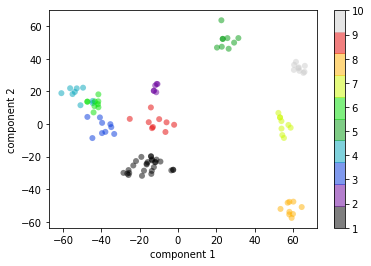

In [31]:
labels = []
features = []
i = 0
for key in support_set_preprocessed:
    i = i + 1
    if (i>10):
        break
    for img in support_set_preprocessed[key]:
        features.append(img)
        labels.append(key)
from sklearn.decomposition import PCA
pca = PCA(2)
projected = pca.fit_transform(features)

plt.scatter(projected[:, 0], projected[:, 1],
            c=labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.savefig('pca_analysis_cross_entropy')

In [20]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
if rotated:
    with open('vgg16-predictions-rotated.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)
else:
    with open('vgg16-predictions.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

NameError: name 'rotated' is not defined

In [39]:
len(test_images)

187

In [ ]:
with open('vgg16-predictions-rotated.pckl','rb') as vgg16:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg16)

In [ ]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [6]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'classes.npy'

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101

In [36]:
img = test_images[idx]
h,w,cx,cy,angle = testing_bboxes[idx]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

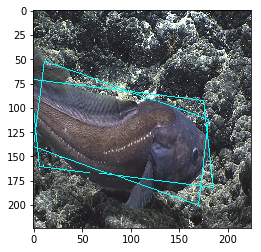

In [28]:
idx = 5
img = test_images[idx]
pts = np.array(test_bboxes[idx])
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [57]:
w,h,cx,cy,angle

(0.9990823, 0.00075547496, 4.3644923e-05, 0.00010419192, 1.4448374e-05)

In [53]:
mod.predict(np.expand_dims(test_images[6],axis=0))

[array([[149.92322 ,  82.941605, 126.17159 , 112.74586 ,  -0.889715]],
       dtype=float32),
 array([[1.1669288e-03, 9.3571018e-08, 7.4474216e-02, 3.6341050e-01,
         5.6094831e-01]], dtype=float32)]

In [16]:
lst = [1,2,3,4,5,6,2]
pred = max(list(lst),key=lst.count)

In [17]:
pred

2